<a href="https://colab.research.google.com/github/auroramugnai/arXiv_classification/blob/main/arXiv_classification/category_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clone the github repository and move to the inner directory.

In [1]:
!git clone https://github.com/auroramugnai/arXiv_classification.git
%cd arXiv_classification/arXiv_classification

Cloning into 'arXiv_classification'...
remote: Enumerating objects: 188, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 188 (delta 51), reused 40 (delta 40), pack-reused 130
Receiving objects: 100% (188/188), 6.56 MiB | 8.77 MiB/s, done.
Resolving deltas: 100% (109/109), done.
/content/arXiv_classification/arXiv_classification


# 1) Build the dataset

In [2]:
import json
import os
import random
import zipfile

import dask.bag as db
import matplotlib.pyplot as plt
import pandas as pd

import utils

In [3]:
SEED = 42 # fix random seed for reproducibility

## Download the dataset


The following line of code comes from clicking on "Copy API command" in https://www.kaggle.com/datasets/Cornell-University/arxiv.

In [4]:
!kaggle datasets download -d Cornell-University/arxiv

Dataset URL: https://www.kaggle.com/datasets/Cornell-University/arxiv
License(s): CC0-1.0
 99% 1.26G/1.28G [00:12<00:00, 110MB/s]
100% 1.28G/1.28G [00:12<00:00, 108MB/s]


Unzip the downloaded file.

In [5]:
with zipfile.ZipFile('./arxiv.zip', 'r') as zip_ref:
    zip_ref.extractall()

The unzipping creates an "arxiv-metadata-oai-snapshot.json". We now create a dask bag out of it.

In [6]:
path = "./arxiv-metadata-oai-snapshot.json"
arxiv_data = db.read_text(path).map(json.loads)
arxiv_data.take(1)

({'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': None,
  'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with d

## Get rid of some unnecessary infomation

In [7]:
# Get the latest version of the articles.
get_latest_version = lambda x: x['versions'][-1]['created']

# Only keep articles published after 2022.
is_after_2022 = lambda x: int(get_latest_version(x).split(' ')[3]) > 2022

# Only keep some information.
cut_info = lambda x: {'id': x['id'],
                      'title': x['title'],
                      'category':x['categories'].split(' '),
                      'abstract':x['abstract'],}

arxiv_data_filtered = (arxiv_data.filter(is_after_2022).map(cut_info).compute())


# Create a pandas dataframe and save it to csv.
df = pd.DataFrame(arxiv_data_filtered)
df.to_csv("./arxiv_data_filtered.csv", index=False)
df.head()

,id,title,category,abstract
0,0705.1329,Third Order Newton's Method for Zernike Polyno...,"[math.NA, cs.NA]",The Zernike radial polynomials are a system ...
1,0706.0190,Quantum Properties and Gravitational Field of ...,[physics.gen-ph],We find that a field with oscillations of ma...
2,0706.0725,Factorization of quadratic polynomials in the ...,"[math.AC, math.GM, math.NT, math.RA]",We establish necessary and sufficient condit...
3,0706.0859,"Profinite complexes of curves, their automorph...","[math.AG, math.NT]","Let ${\cal M}_{g,[n]}$, for $2g-2+n>0$, be t..."
4,0707.0434,Another generalization of Mason's ABC-theorem,[math.NT],We show a generalization of Mason's ABC-theo...


## Balance the dataset

In [8]:
path = "./arxiv_data_filtered.csv"
df = pd.read_csv(path, dtype=str)
df.head()

,id,title,category,abstract
0,0705.1329,Third Order Newton's Method for Zernike Polyno...,"['math.NA', 'cs.NA']",The Zernike radial polynomials are a system ...
1,0706.0190,Quantum Properties and Gravitational Field of ...,['physics.gen-ph'],We find that a field with oscillations of ma...
2,0706.0725,Factorization of quadratic polynomials in the ...,"['math.AC', 'math.GM', 'math.NT', 'math.RA']",We establish necessary and sufficient condit...
3,0706.0859,"Profinite complexes of curves, their automorph...","['math.AG', 'math.NT']","Let ${\cal M}_{g,[n]}$, for $2g-2+n>0$, be t..."
4,0707.0434,Another generalization of Mason's ABC-theorem,['math.NT'],We show a generalization of Mason's ABC-theo...


Set a minimum and maximum threshold for category counts. N.B.: we are referring to category list counts and not single category counts!

In [9]:
num_min = 300
num_max = 400

utils.categories_as_strings(df) # take "category" as a column of strings

# Drop the lists of categories that have less than num_min counts.
cut_num_min = lambda x : len(x) > num_min
df = df.groupby('category').filter(cut_num_min)

# Sample num_max times those categories that have more than num_max counts.
sample_num_max = lambda x: x.sample(min(len(x), num_max))
df = df.groupby('category', as_index = False, group_keys=False)
df = df.apply(sample_num_max).reset_index(drop=True)

print(f"The dataset contains {len(df)} articles.")
df.head()

The dataset contains 63005 articles.


,id,title,category,abstract
0,2309.11558,Estimating major merger rates and spin paramet...,"['astro-ph.CO', 'astro-ph.GA']",We build a model to predict from first princ...
1,2307.13732,The Timeless Timing Argument and the Mass of t...,"['astro-ph.CO', 'astro-ph.GA']",The Timing Argument connects the motion of a...
2,2302.10960,Simulating the LOcal Web (SLOW): I. Anomalies ...,"['astro-ph.CO', 'astro-ph.GA']",Context: Several observations of the local U...
3,2310.08633,Constraining the AGN luminosity function from ...,"['astro-ph.CO', 'astro-ph.GA']",We predict the X-ray background (XRB) expect...
4,2402.01983,Searching for cosmological variation of the pr...,"['astro-ph.CO', 'astro-ph.GA']",Exploring physics beyond General Relativity ...


Visualize the dataset distribution.

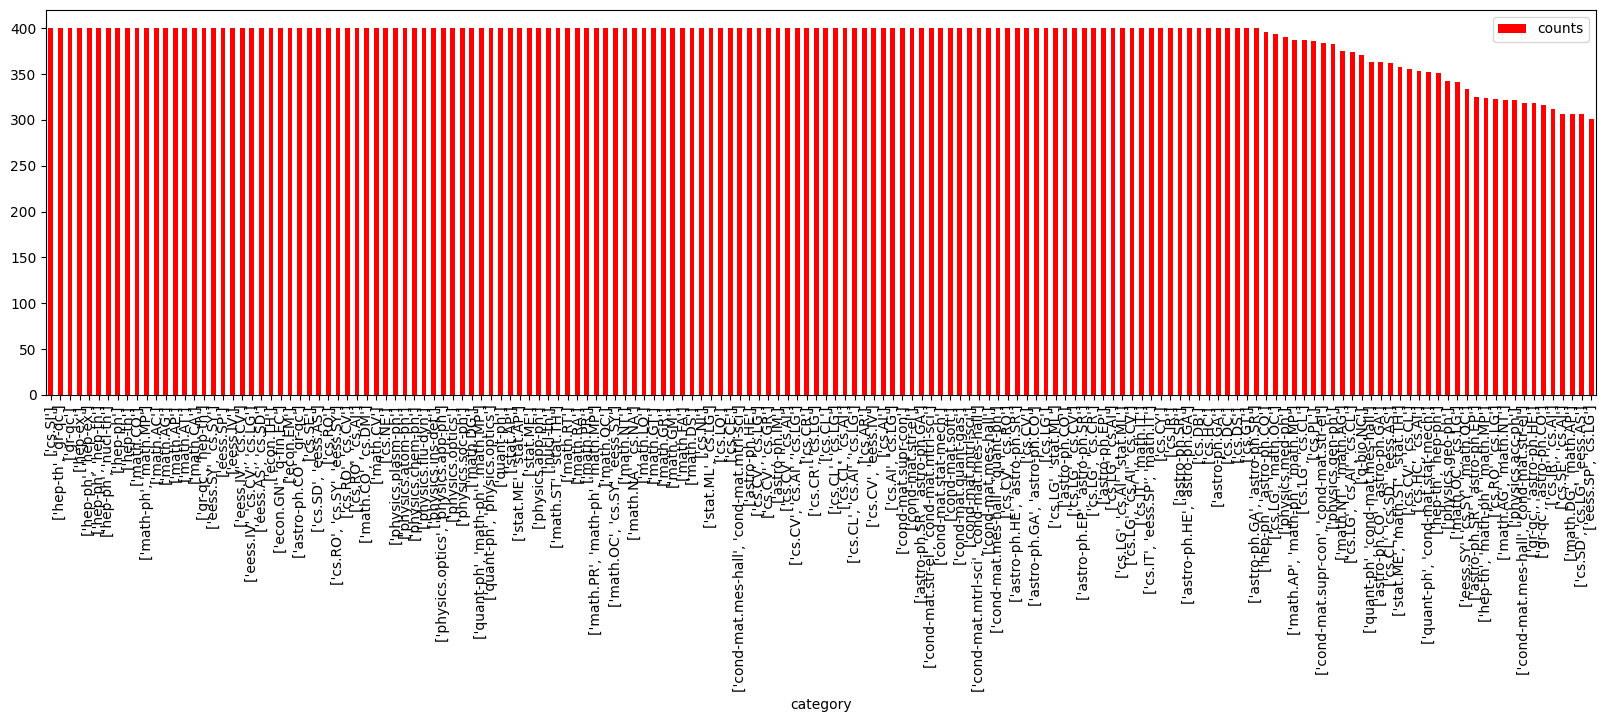

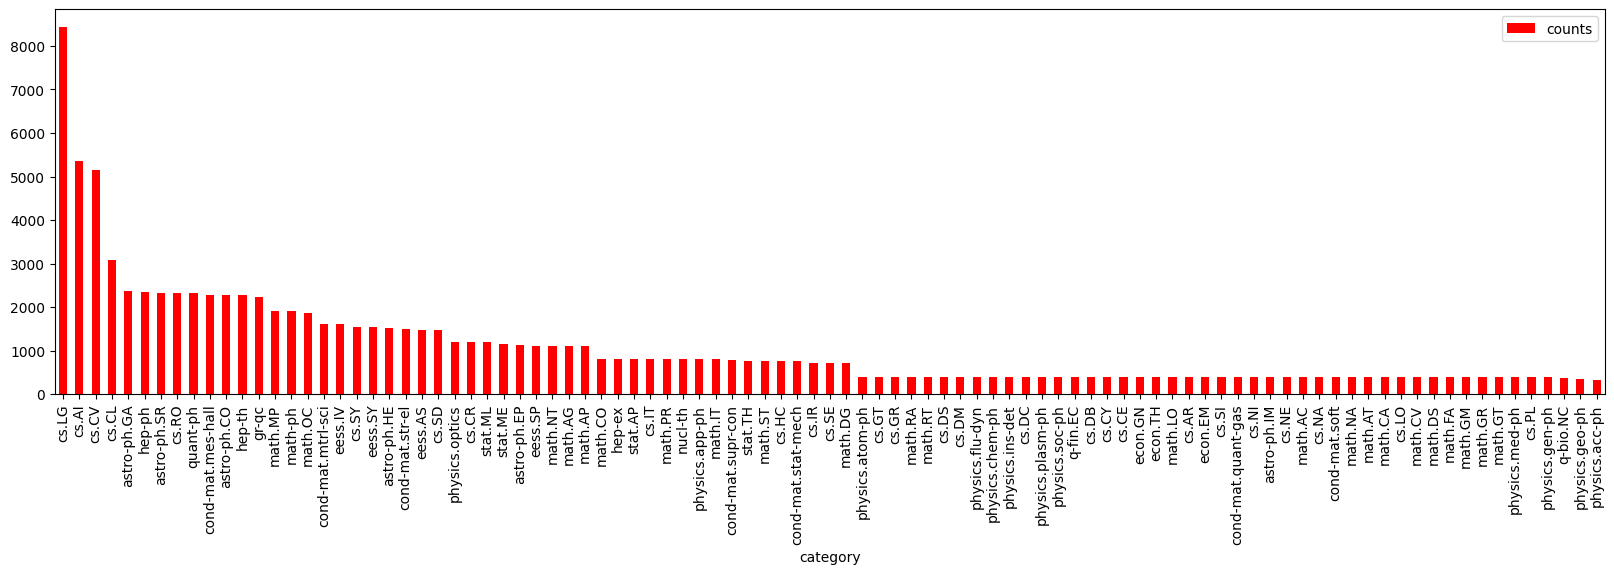

In [10]:
# Get list-of-categories occurrences.
utils.categories_as_strings(df) # take "category" as a column of strings
_ = utils.plot_df_counts(df, col="category")


# Get single-category occurrences.
utils.categories_as_lists(df) # take "category" as a column of lists
df_exp = df.explode("category")
dict_counts_exp = utils.plot_df_counts(df_exp, col="category")

In [11]:
# Get the list of all the single categories.
C  = list(dict_counts_exp.keys())
print(f'Number of categories appearing in the dataset: {len(C)}')

num_to_keep = 20 # Keep only a subset of C.
sub_C = random.sample(C, num_to_keep)
print(f'Number of categories appearing in the dataset: {len(sub_C)}')

# Take only the articles with a list of categories whose elements are in sub_C.
utils.categories_as_lists(df) # take "category" as a column of lists
df = df.loc[df['category'].explode().isin(sub_C).loc[lambda x: x].index]
df.head()

Number of categories appearing in the dataset: 95
Number of categories appearing in the dataset: 20


,id,title,category,abstract
0,2309.11558,Estimating major merger rates and spin paramet...,"[astro-ph.CO, astro-ph.GA]",We build a model to predict from first princ...
1,2307.13732,The Timeless Timing Argument and the Mass of t...,"[astro-ph.CO, astro-ph.GA]",The Timing Argument connects the motion of a...
2,2302.10960,Simulating the LOcal Web (SLOW): I. Anomalies ...,"[astro-ph.CO, astro-ph.GA]",Context: Several observations of the local U...
3,2310.08633,Constraining the AGN luminosity function from ...,"[astro-ph.CO, astro-ph.GA]",We predict the X-ray background (XRB) expect...
4,2402.01983,Searching for cosmological variation of the pr...,"[astro-ph.CO, astro-ph.GA]",Exploring physics beyond General Relativity ...


## Get a fixed number of articles
To speed up computation and avoid a session crash.

In [12]:
num_data = 20000 # number of articles that we want to keep
print(f"The dataset contains {len(df)} articles.")

# Sample the dataset only if its length exceeds num_data.
if(len(df) > num_data):
    n_sample = num_data
    random.seed(SEED)
    df = df.sample(n=n_sample, axis=0)

df.to_csv("./dataset_to_classify.csv", index=False)
print(f"The dataset contains {len(df)} articles.")

The dataset contains 18715 articles.
The dataset contains 18715 articles.


# 2) Multilabel Classification X=abs+tit y=cat


In [13]:
!pip install scikit-multilearn
!pip install neattext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 1.5 MB/s eta 0:00:00


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer,normalize
from sklearn.svm import SVC, LinearSVC

In [15]:
path = "./dataset_to_classify.csv"
df = pd.read_csv(path, dtype=str)
df.tail()

,id,title,category,abstract
18710,2309.06031,High fidelity macroscopic superposition states...,"['quant-ph', 'cond-mat.mes-hall']",A shortcut to adiabatic scheme is proposed f...
18711,2312.12609,Three-photon electron spin resonances,"['quant-ph', 'cond-mat.mes-hall']",We report the observation of a three-photon ...
18712,2303.04090,Assessment of error variation in high-fidelity...,"['quant-ph', 'cond-mat.mes-hall']",Achieving high-fidelity entangling operation...
18713,2311.01509,Photon-resolved Floquet theory in open quantum...,"['quant-ph', 'cond-mat.mes-hall']",Photon-resolved Floquet theory keeps track o...
18714,2209.05469,Optimizing resource efficiencies for scalable ...,"['quant-ph', 'cond-mat.mes-hall']",In the race to build scalable quantum comput...


In [16]:
# Preparing X (features).
X = df["title"] + df["abstract"]


# Preparing y (labels) as a one-hot encoding.
utils.categories_as_lists(df) # take "category" as a column of lists
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df["category"]) # y is now one-hot encoded
classes = mlb.classes_ # names of the columns of the one-hot-encoding


# Split data into train/test.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=SEED)

Visualize y as a one-hot encoding.

In [17]:
y_df = pd.DataFrame(y, columns=classes)
y_df

,astro-ph.CO,astro-ph.GA,cond-mat.mes-hall,cond-mat.mtrl-sci,cond-mat.str-el,cs.AI,cs.AR,cs.CE,cs.CV,cs.DB,...,math.AC,math.AG,math.CV,math.IT,math.MP,math.NT,math.PR,math.RT,q-fin.EC,quant-ph
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18710,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
18711,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
18712,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
18713,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Do the classification.

In [18]:
model = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),
                  ('svm_model', OneVsRestClassifier(LinearSVC(), n_jobs=-1))])

y_pred, mat = utils.run_model_multi(model, X_train, X_test, y_train, y_test)

print(f'accuracy = {accuracy_score(y_test, y_pred)}\n')
print(classification_report(y_test, y_pred,
                            target_names=classes, zero_division=0.0))

accuracy = 0.611219946571683

                   precision    recall  f1-score   support

      astro-ph.CO       0.94      0.94      0.94       646
      astro-ph.GA       0.84      0.85      0.85       230
cond-mat.mes-hall       0.99      0.97      0.98       677
cond-mat.mtrl-sci       0.78      0.64      0.71       228
  cond-mat.str-el       0.83      0.36      0.50       105
            cs.AI       0.55      0.38      0.45       326
            cs.AR       0.91      0.75      0.82       115
            cs.CE       0.90      0.50      0.64       129
            cs.CV       0.80      0.67      0.73       248
            cs.DB       0.89      0.70      0.78       130
            cs.DC       0.90      0.63      0.74       116
            cs.HC       0.90      0.75      0.82       227
            cs.IR       0.99      0.87      0.93       214
            cs.IT       0.75      0.69      0.72       119
            cs.LG       0.65      0.32      0.43       189
            cs.NE       0

Plot confusion matrices.

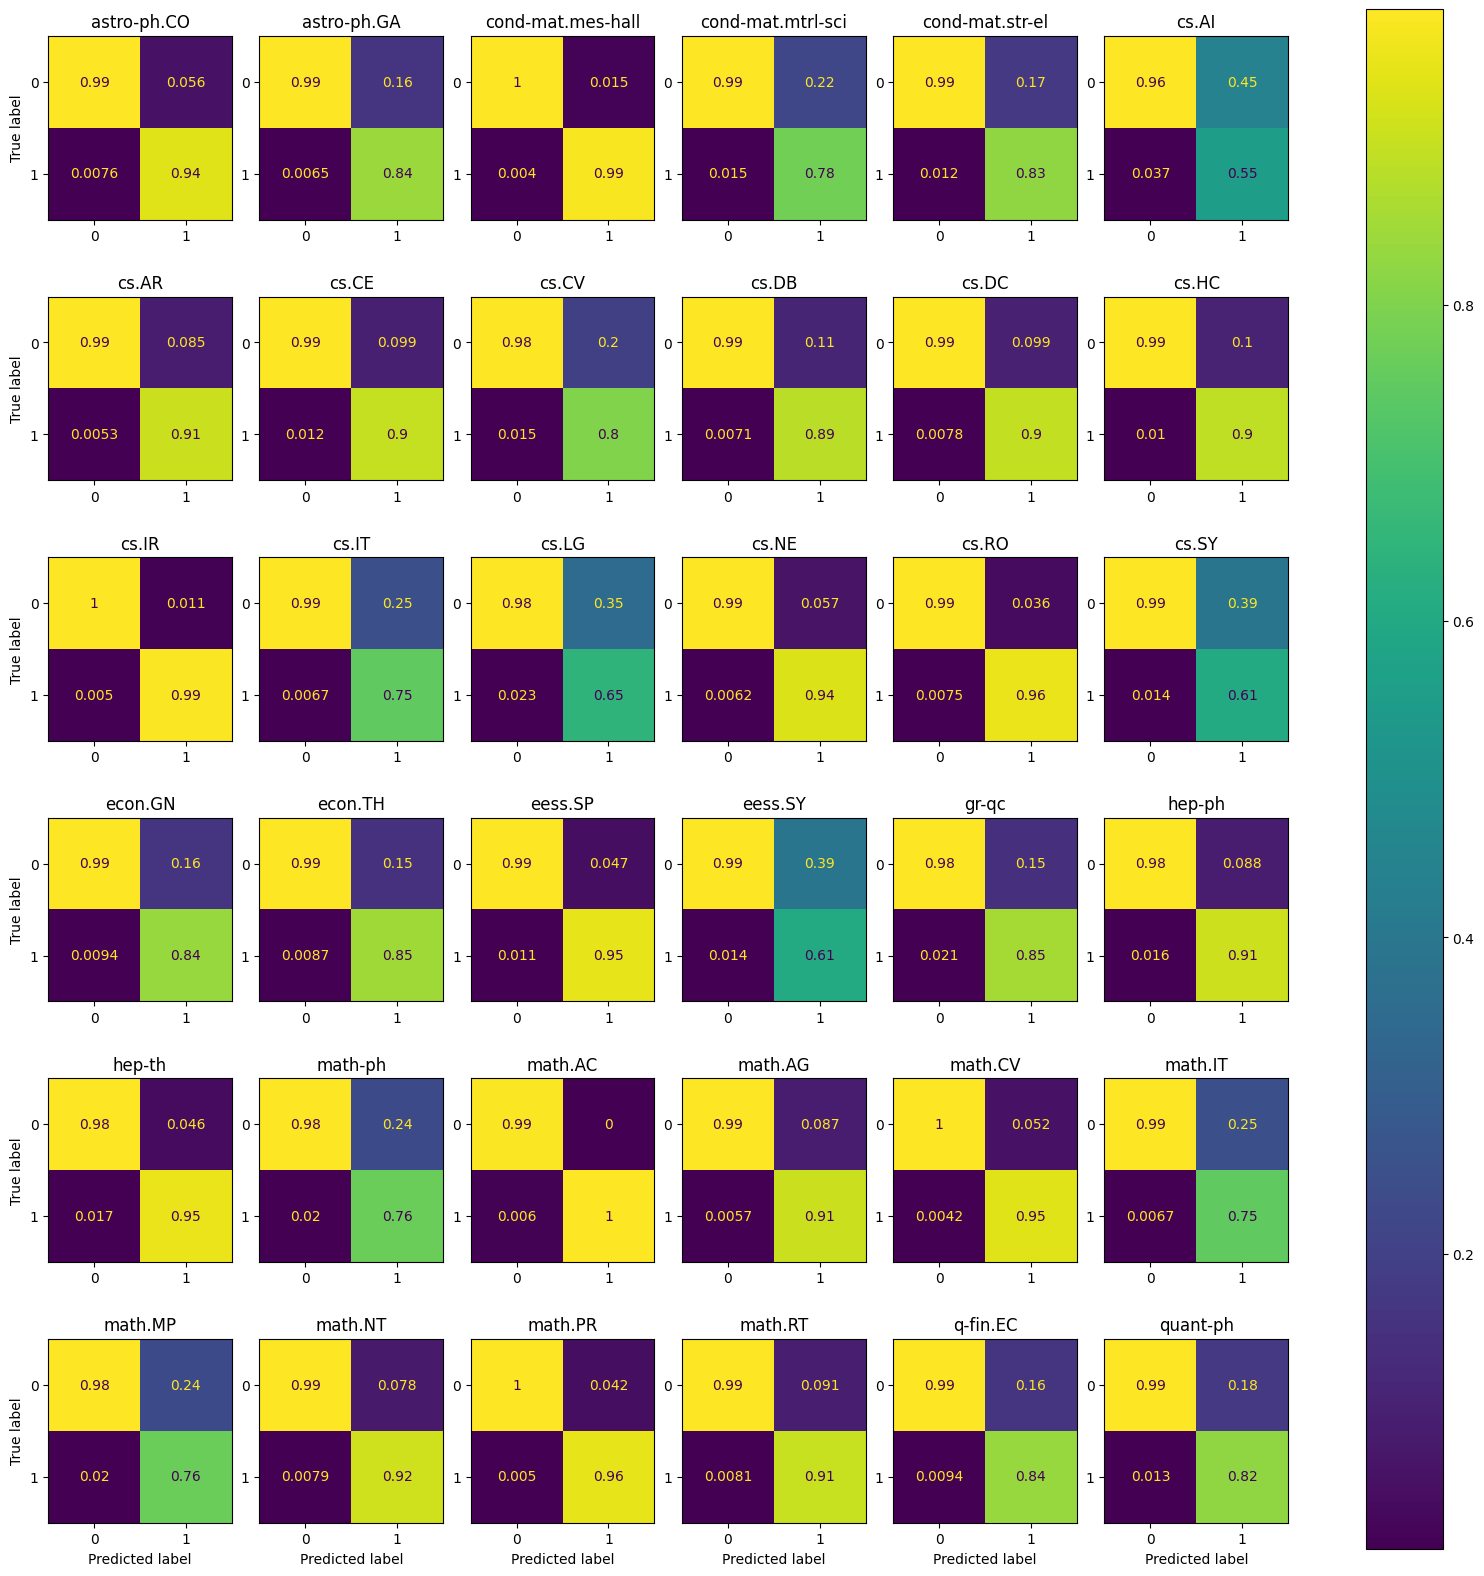

In [19]:
utils.print_confusion_matrices(mat, classes)

(Optional) Show some predictions.

In [20]:
# Check the first 10 predictions.
y_test_list = mlb.inverse_transform(y_test)[:10]
y_pred_list = mlb.inverse_transform(y_pred)[:10]

for yt, yp in zip(y_test_list, y_pred_list):
  print("-"*20)
  print(f"  true   : {yt}")
  print(f"predicted: {yp}")

--------------------
  true   : ('cs.AI', 'cs.RO')
predicted: ('cs.AI', 'cs.LG', 'cs.RO')
--------------------
  true   : ('hep-th', 'math-ph', 'math.MP')
predicted: ('hep-th',)
--------------------
  true   : ('math.AG', 'math.NT')
predicted: ('math.AG', 'math.NT')
--------------------
  true   : ('gr-qc', 'hep-th')
predicted: ('gr-qc', 'hep-th')
--------------------
  true   : ('math.CV',)
predicted: ('math.CV',)
--------------------
  true   : ('astro-ph.CO', 'hep-ph')
predicted: ('astro-ph.CO', 'hep-ph')
--------------------
  true   : ('astro-ph.CO', 'astro-ph.GA')
predicted: ('astro-ph.CO', 'astro-ph.GA')
--------------------
  true   : ('cs.RO',)
predicted: ('cs.RO',)
--------------------
  true   : ('gr-qc', 'hep-th')
predicted: ('gr-qc', 'hep-th')
--------------------
  true   : ('gr-qc', 'hep-th')
predicted: ('hep-th',)


Plot the ROC curve.

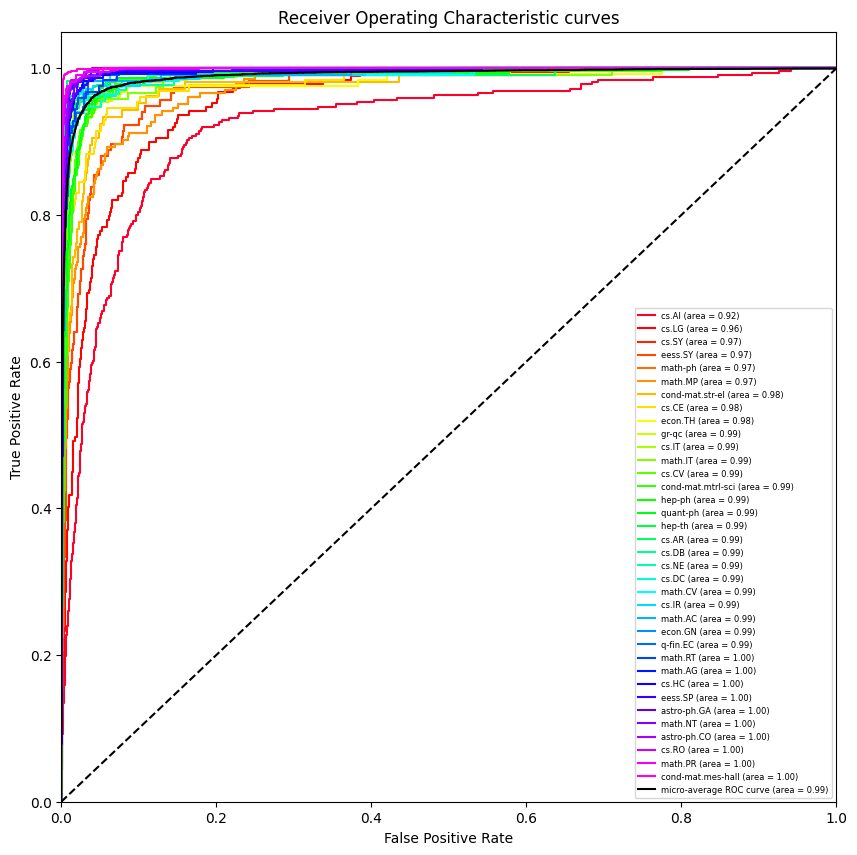

In [21]:
y_score = model.fit(X_train, y_train).decision_function(X_test)
utils.ROC(classes, y_test, y_score)

# 3) Keywords extraction

In [22]:
!pip install KeyBERT -q
!pip install keyphrase-vectorizers -q
!pip install neattext -q
!pip install nltk -q
!pip install sematch -q
!pip install -U spacy -q # spacy package to preprocess the abstract text
!python -m spacy download en_core_web_sm -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.8/197.8 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.3/240.3 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.5/363.5 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.8/772.8 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.3/236.3 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.0/314.0 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 28.6

In [ ]:
# import string

import en_core_web_sm
from keybert import KeyBERT
# from keyphrase_vectorizers import KeyphraseCountVectorizer
import neattext.functions as nfx
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from tqdm import tqdm

Clean out the strings (this step will take a while).

In [24]:
# Remove stop words, punctuation, special characters, numbers.
nlp = spacy.load("en_core_web_sm")
tqdm.pandas() # to display progress bar

# First on abstracts.
clean_abs = lambda x: utils.remove(text=x["abstract"], nlp=nlp)
# df['abstract'] = df['abstract'].progress_apply(nfx.remove_stopwords)
df["clean_abstract"] = df.progress_apply(clean_abs, axis=1)

# Then on titles.
clean_tit = lambda x: utils.remove(text=x["title"], nlp=nlp)
# df["title"] = df['title'].progress_apply(nfx.remove_stopwords)
df["clean_title"] = df.progress_apply(clean_tit, axis=1)

df.tail()

100%|██████████| 18715/18715 [02:29<00:00, 124.95it/s]


,id,title,category,abstract,clean_abstract,clean_title
18710,2309.06031,High fidelity macroscopic superposition states...,"[quant-ph, cond-mat.mes-hall]",shortcut adiabatic scheme proposed preparing m...,shortcut adiabatic scheme propose prepare mass...,high fidelity macroscopic superposition state ...
18711,2312.12609,Three-photon electron spin resonances,"[quant-ph, cond-mat.mes-hall]",report observation three-photon resonant trans...,report observation three photon resonant trans...,three photon electron spin resonance
18712,2303.04090,Assessment error variation high-fidelity two-q...,"[quant-ph, cond-mat.mes-hall]",Achieving high-fidelity entangling operations ...,achieve high fidelity entangle operation qubit...,assessment error variation high fidelity two q...
18713,2311.01509,Photon-resolved Floquet theory open quantum sy...,"[quant-ph, cond-mat.mes-hall]",Photon-resolved Floquet theory keeps track pho...,photon resolve floquet theory keep track photo...,photon resolve floquet theory open quantum system
18714,2209.05469,Optimizing resource efficiencies scalable full...,"[quant-ph, cond-mat.mes-hall]","race build scalable quantum computers, minimiz...",race build scalable quantum computer minimize ...,optimize resource efficiency scalable full sta...


In [25]:
# Add a space to separate title and abstract.
df["clean_title"] = df["clean_title"].astype(str) + " "
df["text"] = df["clean_title"] + df["clean_abstract"]

# Save to csv
df.to_csv(f"./processed_dataframe.csv", index=False)
df.head()

,id,title,category,abstract,clean_abstract,clean_title,text
0,2309.11558,Estimating major merger rates spin parameters ...,"[astro-ph.CO, astro-ph.GA]",build model predict principles properties majo...,build model predict principle propertie major ...,estimate major merger rate spin parameter ab i...,estimate major merger rate spin parameter ab i...
1,2307.13732,Timeless Timing Argument Mass Local Group,"[astro-ph.CO, astro-ph.GA]",Timing Argument connects motion two-body syste...,time argument connect motion two body system m...,timeless timing argument mass local group,timeless timing argument mass local group time...
2,2302.10960,Simulating LOcal Web (SLOW): I. Anomalies loca...,"[astro-ph.CO, astro-ph.GA]",Context: observations local Universe (LU) poin...,context observation local universe lu point ex...,simulate local web slow anomalies local densit...,simulate local web slow anomalies local densit...
3,2310.08633,Constraining AGN luminosity function JWST X-ra...,"[astro-ph.CO, astro-ph.GA]",predict X-ray background (XRB) expected popula...,predict x ray background xrb expect population...,constrain agn luminosity function jwst x ray b...,constrain agn luminosity function jwst x ray b...
4,2402.01983,Searching cosmological variation proton-to-ele...,"[astro-ph.CO, astro-ph.GA]",Exploring physics General Relativity Standard ...,explore physics general relativity standard mo...,search cosmological variation proton to electr...,search cosmological variation proton to electr...


## Extract the keywords

In [38]:
df2 = df.copy(deep=False)

kw_model = KeyBERT('all-mpnet-base-v2')
extraction = lambda x: utils.extract_kws(TEXT=x["text"],
                                   kw_model=kw_model,
                                   seed=x["clean_title"].split(" "))
df2["keywords"] = df2.progress_apply(extraction, axis=1)
df2.head()

100%|██████████| 18715/18715 [29:39<00:00, 10.51it/s]


,id,title,category,abstract,clean_abstract,clean_title,text,keywords
0,2309.11558,Estimating major merger rates spin parameters ...,"[astro-ph.CO, astro-ph.GA]",build model predict principles properties majo...,build model predict principle propertie major ...,estimate major merger rate spin parameter ab i...,estimate major merger rate spin parameter ab i...,"[coalescence, merger, cosmic, peak]"
1,2307.13732,Timeless Timing Argument Mass Local Group,"[astro-ph.CO, astro-ph.GA]",Timing Argument connects motion two-body syste...,time argument connect motion two body system m...,timeless timing argument mass local group,timeless timing argument mass local group time...,"[cosmic, gravitate, time, masse]"
2,2302.10960,Simulating LOcal Web (SLOW): I. Anomalies loca...,"[astro-ph.CO, astro-ph.GA]",Context: observations local Universe (LU) poin...,context observation local universe lu point ex...,simulate local web slow anomalies local densit...,simulate local web slow anomalies local densit...,"[galaxy, anomalies, simulation, local]"
3,2310.08633,Constraining AGN luminosity function JWST X-ra...,"[astro-ph.CO, astro-ph.GA]",predict X-ray background (XRB) expected popula...,predict x ray background xrb expect population...,constrain agn luminosity function jwst x ray b...,constrain agn luminosity function jwst x ray b...,"[quasar, luminosity, background, xrb]"
4,2402.01983,Searching cosmological variation proton-to-ele...,"[astro-ph.CO, astro-ph.GA]",Exploring physics General Relativity Standard ...,explore physics general relativity standard mo...,search cosmological variation proton to electr...,search cosmological variation proton to electr...,"[cosmological, proton, qso, variation]"


In [39]:
df2.to_csv(f"./keywords.csv", index=False) # Save to csv

# 4) Classification X=kws, y=cat


In [40]:
path = "./keywords.csv"
df = pd.read_csv(path, dtype=str)
df.tail()

,id,title,category,abstract,clean_abstract,clean_title,text,keywords
18710,2309.06031,High fidelity macroscopic superposition states...,"['quant-ph', 'cond-mat.mes-hall']",shortcut adiabatic scheme proposed preparing m...,shortcut adiabatic scheme propose prepare mass...,high fidelity macroscopic superposition state ...,high fidelity macroscopic superposition state ...,"['superconducte', 'superposition', 'adiabatici..."
18711,2312.12609,Three-photon electron spin resonances,"['quant-ph', 'cond-mat.mes-hall']",report observation three-photon resonant trans...,report observation three photon resonant trans...,three photon electron spin resonance,three photon electron spin resonance report ob...,"['photon', 'spin', 'spectroscopy', 'edmr']"
18712,2303.04090,Assessment error variation high-fidelity two-q...,"['quant-ph', 'cond-mat.mes-hall']",Achieving high-fidelity entangling operations ...,achieve high fidelity entangle operation qubit...,assessment error variation high fidelity two q...,assessment error variation high fidelity two q...,"['qubit', 'silicon', 'error', 'consistently']"
18713,2311.01509,Photon-resolved Floquet theory open quantum sy...,"['quant-ph', 'cond-mat.mes-hall']",Photon-resolved Floquet theory keeps track pho...,photon resolve floquet theory keep track photo...,photon resolve floquet theory open quantum sys...,photon resolve floquet theory open quantum sys...,"['photon', 'entanglement', 'spectroscopy', 'fl..."
18714,2209.05469,Optimizing resource efficiencies scalable full...,"['quant-ph', 'cond-mat.mes-hall']","race build scalable quantum computers, minimiz...",race build scalable quantum computer minimize ...,optimize resource efficiency scalable full sta...,optimize resource efficiency scalable full sta...,"['qubit', 'compute', 'superconducte', 'efficie..."


In [41]:
# Preparing X (features).
X = df["keywords"]


# Split data into train/test.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=SEED)

In [42]:
y_pred, mat = utils.run_model_multi(model, X_train, X_test, y_train, y_test)

print(f'accuracy = {accuracy_score(y_test, y_pred)}\n')
print(classification_report(y_test, y_pred,
                            target_names=classes, zero_division=0.0))

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


accuracy = 0.4806767586821015

                   precision    recall  f1-score   support

      astro-ph.CO       0.91      0.91      0.91       646
      astro-ph.GA       0.74      0.74      0.74       230
cond-mat.mes-hall       0.97      0.92      0.94       677
cond-mat.mtrl-sci       0.68      0.57      0.62       228
  cond-mat.str-el       0.58      0.20      0.30       105
            cs.AI       0.51      0.34      0.41       326
            cs.AR       0.85      0.64      0.73       115
            cs.CE       0.84      0.25      0.38       129
            cs.CV       0.74      0.51      0.60       248
            cs.DB       0.86      0.57      0.69       130
            cs.DC       0.76      0.52      0.62       116
            cs.HC       0.82      0.56      0.67       227
            cs.IR       0.94      0.78      0.85       214
            cs.IT       0.62      0.52      0.57       119
            cs.LG       0.45      0.21      0.29       189
            cs.NE       

Plot confusion matrices.

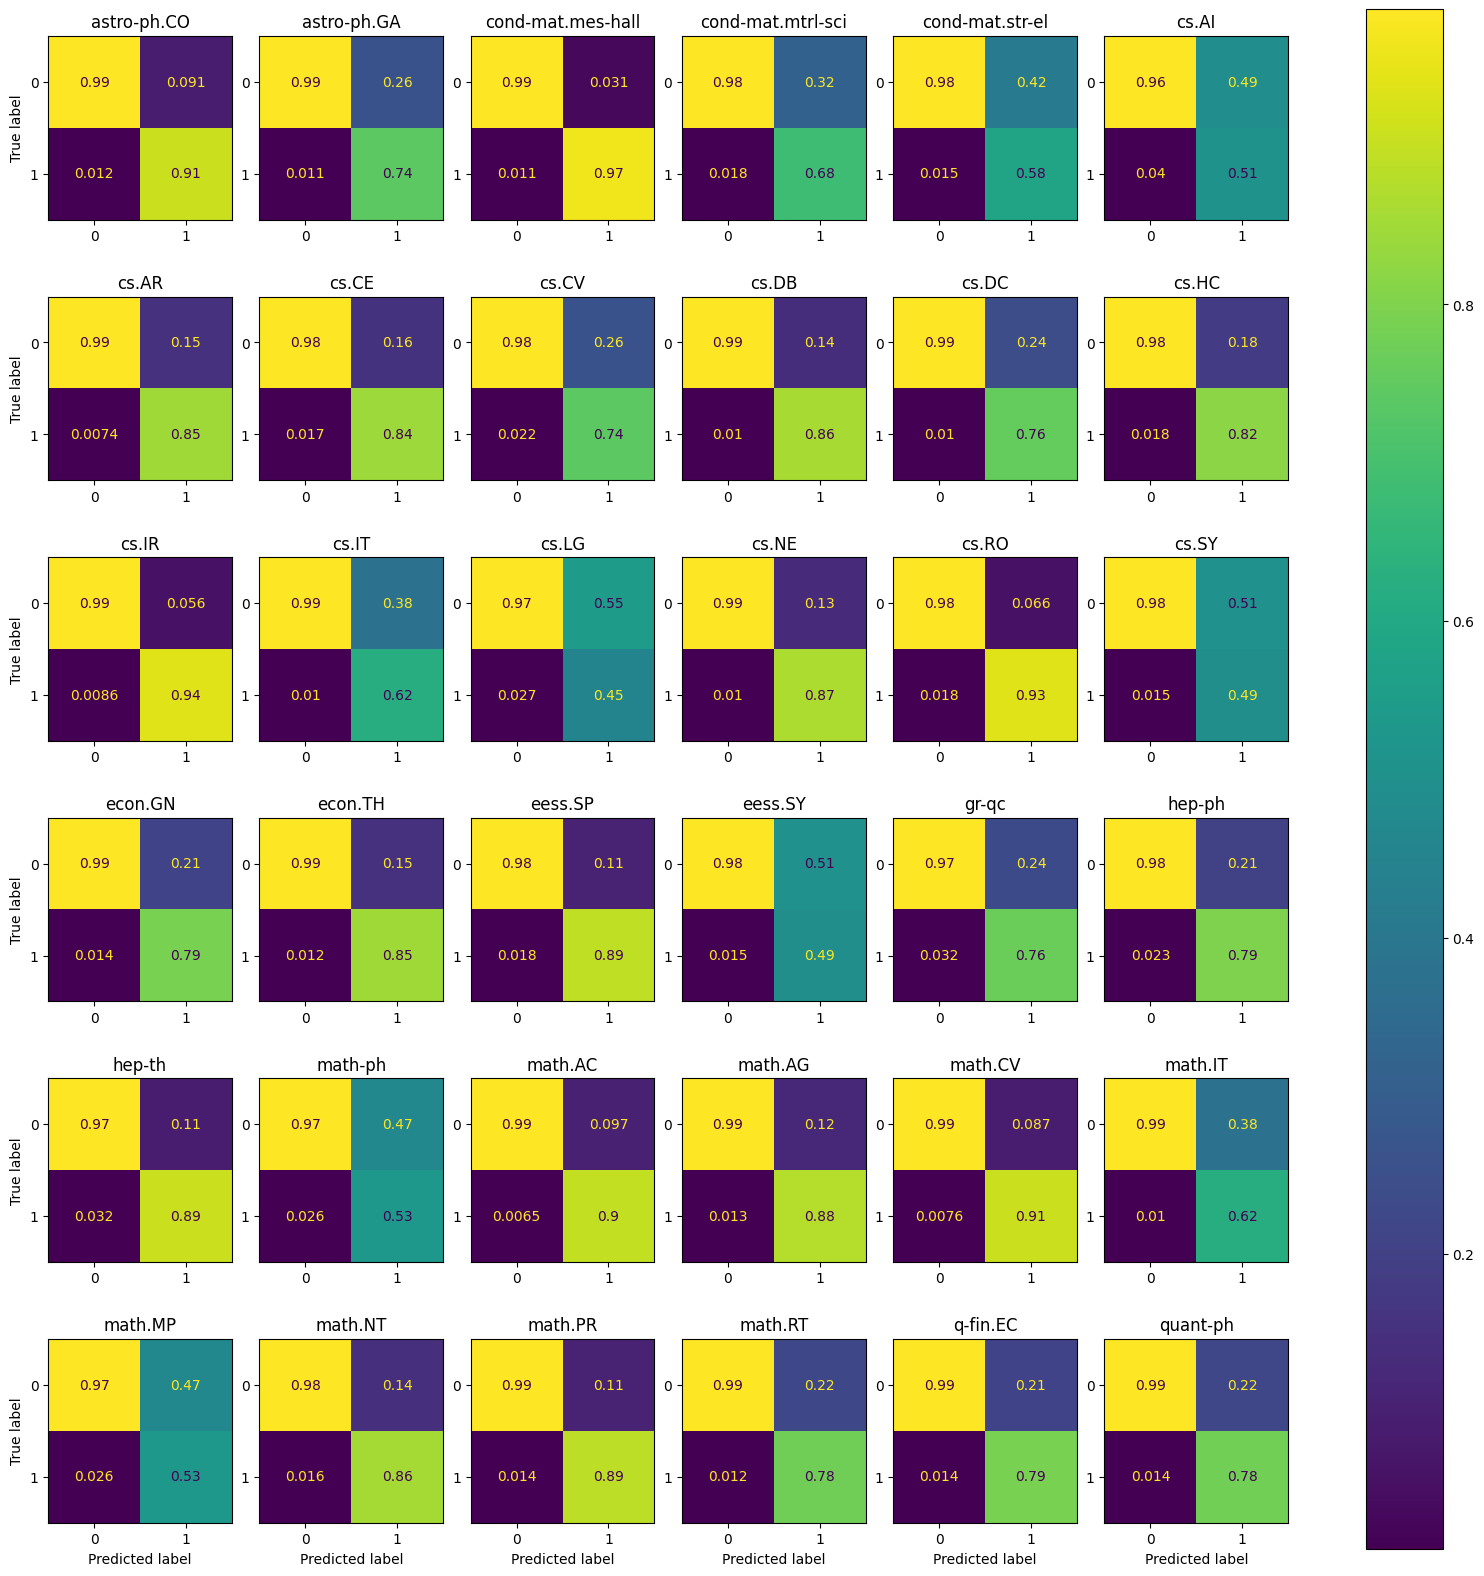

In [43]:
utils.print_confusion_matrices(mat, classes)

(Optional) Show some predictions.

In [ ]:
# Check the first 10 predictions.
y_test_list = mlb.inverse_transform(y_test)[:10]
y_pred_list = mlb.inverse_transform(y_pred)[:10]

for yt, yp in zip(y_test_list, y_pred_list):
  print("-"*20)
  print(f"  true   : {yt}")
  print(f"predicted: {yp}")

--------------------
  true   : ('cs.AI', 'cs.RO')
predicted: ('cs.AI', 'cs.LG', 'cs.RO')
--------------------
  true   : ('hep-th', 'math-ph', 'math.MP')
predicted: ('hep-th',)
--------------------
  true   : ('math.AG', 'math.NT')
predicted: ('math.AG', 'math.NT')
--------------------
  true   : ('gr-qc', 'hep-th')
predicted: ('gr-qc', 'hep-th')
--------------------
  true   : ('math.CV',)
predicted: ('math.CV',)
--------------------
  true   : ('astro-ph.CO', 'hep-ph')
predicted: ('astro-ph.CO', 'hep-ph')
--------------------
  true   : ('astro-ph.CO', 'astro-ph.GA')
predicted: ('astro-ph.CO', 'astro-ph.GA')
--------------------
  true   : ('cs.RO',)
predicted: ('cs.RO',)
--------------------
  true   : ('gr-qc', 'hep-th')
predicted: ('gr-qc', 'hep-th')
--------------------
  true   : ('gr-qc', 'hep-th')
predicted: ('hep-th',)


Plot the ROC curve.

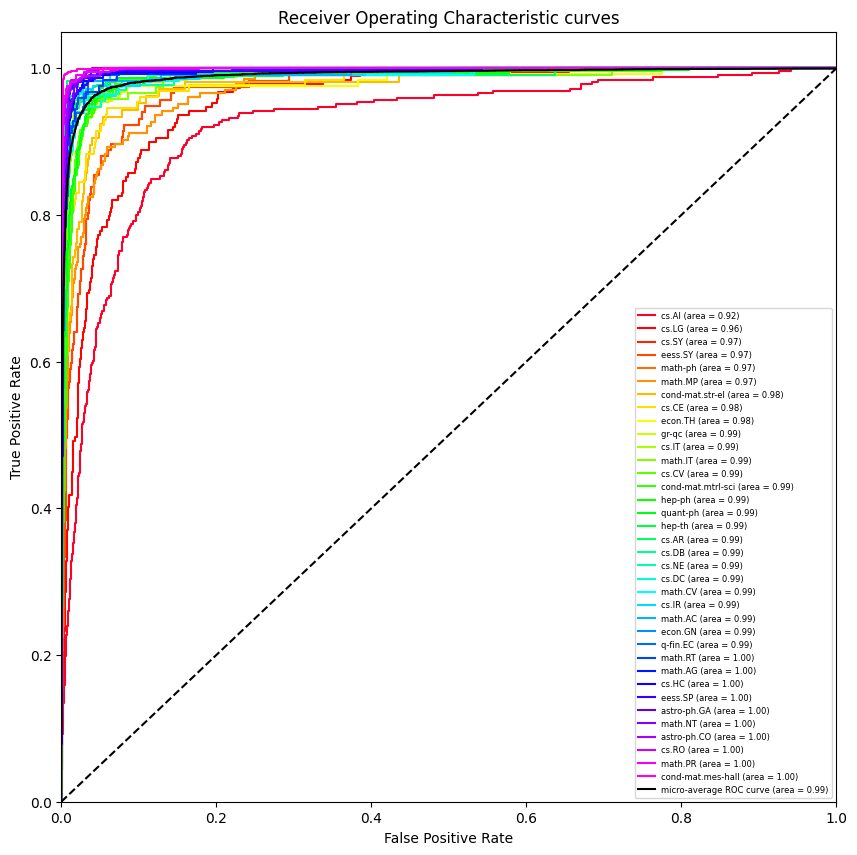

In [ ]:
y_score = model.fit(X_train, y_train).decision_function(X_test)
utils.ROC(classes, y_test, y_score)